# Étude modélisation 2D irregular BPP

Dans ce notebook on étudie l'implémentation du problème de bin packing avec des formes irrégulières.

http://www.cs.stir.ac.uk/~goc/papers/EffectiveHueristic2DAOR2013.pdf

http://eprints.whiterose.ac.uk/139290/1/BCP-EJOR.pdf

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from ortools.sat.python import cp_model

import matplotlib
import matplotlib.pyplot as plt
import functools 

import uuid

In [2]:
class Box(object):
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y):
        self.__name = name
        self.__pos_x = int(pos_x)
        self.__pos_y = int(pos_y)
        self.__dim_x = int(dim_x)
        self.__dim_y = int(dim_y)

    @property
    def name(self):
        return self.__name
    
    @property
    def pos_x(self):
        return self.__pos_x
    
    @property
    def pos_y(self):
        return self.__pos_y
    
    @property
    def dim_x(self):
        return self.__dim_x
    
    @property
    def dim_y(self):
        return self.__dim_y
    
    @name.setter
    def name(self, value):
        self.__name = value
    
    @pos_x.setter
    def pos_x(self, value):
        self.__pos_x = value
    
    @pos_y.setter
    def pos_y(self, value):
        self.__pos_y = value
        
    @dim_x.setter
    def dim_x(self, value):
        self.__dim_x = value
        
    @dim_y.setter
    def dim_y(self, value):
        self.__dim_y = value


In [3]:
class Shape(object):
    def __init__(self, piece_coordinates):
        self.__coordinates = piece_coordinates
    
    @property
    def coordinates(self):
        return self.__coordinates
    

In [4]:
class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, variable_list, limit):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variable_list = variable_list
        self.__solution_count = 0
        self.__solution_limit = limit

    def on_solution_callback(self):
        self.__solution_count += 1
        fig = plt.figure()
        ax = fig.add_subplot(111)
       
        colors = ['gold', 'red', 'yellow', 'pink', 'blue', 'cyan', 'black', 'magenta']
        
        for shape, color in zip(self.__variable_list, colors):
            l = []
            for elem in shape:
                print('({},{})'.format(self.Value(elem[0]), self.Value(elem[1])))
                l.append([self.Value(elem[0]), self.Value(elem[1])])
                
        rect = matplotlib.patches.Polygon(l,  color)
        ax.add_patch(rect)
        plt.xlim([0,10])
        plt.ylim([0, 10])
        plt.gca().set_aspect('equal', adjustable='box')    
        plt.show()
        
        

    def solution_count(self):
        return self.__solution_count

In [5]:
class BlockBoxProblemBis(object):
    def __init__(self, box):
        # model initialisation
        self.__model = cp_model.CpModel()
        # solver creation
        self.__solver = cp_model.CpSolver()
        
        # init main box
        self.__box = box

        # init list of blocks
        self.__block_list = []
    
    @property
    def box(self):
        return self.__box
    
    @property
    def model(self):
        return self.__model
    
    @property
    def solver(self):
        return self.__solver
    
    @box.setter
    def box(self, value):
        self.__box = value

    @model.setter
    def model(self, value):
        self.__model = value
    
    @solver.setter
    def solver(self, value):
        self.__solver = value
        
    def check_inside(self, x, y):
        self.__model.Add(x >= self.__box.pos_x)
        self.__model.Add(y >= self.__box.pos_y)
        self.__model.Add(x <= self.__box.pos_x + self.__box.dim_x)
        self.__model.Add(y <= self.__box.pos_y + self.__box.dim_y)  
        
    def addShape(self, shape):
        array = []
        
        lowestA = min(shape.coordinates, key = lambda a: a.x)
        
        x = self.__model.NewIntVar(0, self.__box.dim_x, 'b%i_pos_x' % len(self.__block_list))    
        y = self.__model.NewIntVar(0, self.__box.dim_y, 'b%i_pos_y' % len(self.__block_list)) 
        
        diff = y - x
        self.__model.Add(y == x + diff)
        self.check_inside(x, y)
        array.append((x, y))
        
        for coordinate in shape.coordinates:
            
            if lowestA != coordinate:
                pos_x = self.__model.NewIntVar(0, self.__box.dim_x, 'b%i_pos_x' % len(self.__block_list))    
                pos_y = self.__model.NewIntVar(0, self.__box.dim_y, 'b%i_pos_y' % len(self.__block_list)) 
                self.__model.Add(pos_x == x + ( coordinate.x - lowestA.x ))
                self.__model.Add(pos_y == y + ( coordinate.y - lowestA.y))
                self.check_inside(pos_x, pos_y)
                array.append((pos_x, pos_y))
        
        self.__block_list.append(array)

            
    def solve(self):  
        solution_printer = VarArraySolutionPrinter(self.__block_list, 5)
        status = self.__solver.SearchForAllSolutions(self.__model, solution_printer)

        print('Status = %s' % self.__solver.StatusName(status))
        print('Number of solutions found: %i' % solution_printer.solution_count())

In [6]:
class Point(object):
    def __init__(self, x_value, y_value):
        self.__x = x_value
        self.__y = y_value
       
    @property
    def x(self):
        return self.__x
    
    @property
    def y(self):
        return self.__y
    
    @x.setter
    def x(self, value):
        self.__x = value
        
    @y.setter
    def y(self, value):
        self.__y = value
    
    def __str__(self):
        return ('({}, {})'.format(self.__x, self.__y))
        

In [7]:
def onSegment(p, q, r):
    """ Given three points p, q, r, the function checks if
    point q lies on line segment 'pr' 
    Args:
        p (Point): Point p
        q (Point): Point q
        r (Point): Point r
    Returns:
      True if on
      False otherwise
    """
     # p != r
    assert p != r
    dxc = q.x - p.x
    dyc = q.y - p.y
    dxl = r.x - p.x
    dyl = r.y - p.y
    cross = dxc * dyl - dyc * dxl
    if (cross != 0):
        return False
    
    if (abs(dxl) >= abs(dyl)):
        return p.x <= q.x and q.x <= r.x if dxl > 0 else r.x <= q.x and q.x <= p.x
    else:
        return p.y <= q.y and q.y <= r.y if dyl > 0 else r.y <= q.y and q.y <= p.y

def intersection(p,q,r):
    """ Find orientation of ordered triplet (p, q, r).
    Args:
        p (tuple): Point p
        q (tuple): Point q
        r (tuple): Point r
    Returns:
        0 if p, q and r are colinear
        1 if Clockwise
        2 if CounterClockwise
    """
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/ 
    # for details of below formula. 
    val = (q.y - p.y)* (r.x - q.x) - (q.x - p.x)*(r.y - q.y)
    if val == 0: # colinear
        return 0
    
    return 1 if val > 0 else 2 # clock or counterclock wise
  
    
def edgesIntersection(p1,q1,p2,q2):
    """ Check if line segment 'p1q1' and 'p2q2' intersect
    Args:
        p1 (tuple): Point p1
        q1 (tuple): Point q1
        p2 (tuple): Point p2
        q2 (tuple): Point p2

    Returns:
        True if line segment intersect
        False otherwise
    """
    o1 = intersection(p1,q1,p2)
    o2 = intersection(p1,q1,q2)
    o3 = intersection(p2,q2,p1)
    o4 = intersection(p2,q2,q1)
    
    if (o1 != o2 and o3 != o4):
        return True
    if (o1 == 0 and onSegment(p1,p2,q1)):
        return True
    if (o2 == 0 and onSegment(p1,q2,q1)):
        return True
    if (o3 == 0 and onSegment(p2,p1,q2)):
        return True
    if (o4 == 0 and onSegment(p2,q1,q2)):
        return True
    return False
    
def getEdgesPiece(points_list):
    edges = []
    edges.append([points_list[-1], points_list[0]])
    index = 0
    while index < len(points_list):
        if index < len(points_list) - 1:
            edges.append([points_list[index], points_list[index+1]])
        index += 1
    return edges


In [8]:
def intersectEachOther(p1, p2):
    """ Decide if two pieces intersects each other.
    Args: 
        p1 (list): list of Points of  piece P1
        p2 (list): list of Points of piece P2
    Returns:
        A boolean value indicating whether the two pieces intersects each other.
    """
    # looking for the smallest x
    p1_leftmost_end = min(p1, key = lambda t: t.x)
    # looking for the biggest x 
    p1_rightmost_end = max(p1, key = lambda t: t.x)
    # looking for the smallest y
    p1_lowest_end = min(p1, key = lambda t: t.y)
    # looking for the biggest y
    p1_upper_end = max(p1, key = lambda t: t.y)
    
    p2_leftmost_end = min(p2, key = lambda t: t.x)
    p2_rightmost_end = max(p2, key = lambda t: t.x)
    p2_lowest_end = min(p2, key = lambda t: t.y)
    p2_upper_end = max(p2, key = lambda t: t.y)


    if p1_lowest_end.y > p2_upper_end.y or p2_lowest_end.y > p1_upper_end.y:
        return False
    
    if p1_leftmost_end.x > p2_rightmost_end.x or p2_leftmost_end.x > p1_rightmost_end.x:
        return False
    
    
    p1_edges = getEdgesPiece(p1)
    p2_edges = getEdgesPiece(p2)
    
    for e1 in p1_edges:
        for e2 in p2_edges:
            if edgesIntersection(e1[0], e1[1], e2[0], e2[1]):
                return True
    return False

In [9]:
def sign(x):
    """Determine sign of number
    Args:
        number:
    Returns:
        0  if negative
        1 if positive
    """
    return int(x>0)

def find_area(array):
    a = 0
    p1 = array[0]
    for p in array[1:]:
        a += (p.x * p1.y - p.y * p1.x)
        p1.x,p1.y = p.x, p.y
    return a/2

def Dfunction(a, b, p):
    """ Gives the relative position of a point P
    with respect to an oriented edge AB
    Args:
        a (Point): first point of edge AB 
        b (Point): second point of edge AB
        p (Point): point to check
    Returns:
        negative or positive, the point P is on the left or
        the right side of the edge AB.
    """
    return (a.x - b.x) * (a.y - p.y) - (a.y - b.y)*(a.x - p.x)

def isPointInsideShape(p, point):
    """Decide if a point is inside a shape
    Args:
        p (list): all points of a piece
        point (Point): point to check
    Returns:
        A boolean value indicating whether the point
        is or not inside the piece.
    """
    # looking for the smallest y
    p_lowest_part = min(p, key = lambda t: t.x)
    
    # looking for the biggest y
    p_upper_part = max(p, key = lambda t: t.x)
    
    # looking for the smallest x
    p_leftmost_end = min(p, key = lambda t: t.y)
    
    # looking for the biggest x 
    p_rightmost_end = max(p, key = lambda t: t.y)

    if point.x <= p_lowest_part.x or point.x >= p_upper_part.x:
        return False
    
    if point.y <= p_leftmost_end.y or point.y >= p_rightmost_end.y:
        return False
    
    for vertex in p:
        if vertex == point:
            return False
    
    sides = getEdgesPiece(p)

    
    for side in sides:
        if onSegment(side[0], point, side[1]):
            return False
    
    # maybe random larger number
    M = p_rightmost_end.x + 100
    new_point = Point(M, point.y)
    
    counter = 1
    
    for side in sides:
        if edgesIntersection(side[0], side[1], point, new_point):
            counter += 1
    
    for i, vertex in enumerate(p):
        
        if onSegment(point, vertex, new_point):
            d1 = Dfunction(point, new_point, p[i - 1])
            d2 = Dfunction(point, new_point, p[i + 1])
                
            if sign(d1) != sign(d2): 
                counter += 1   

    if counter % 2 == 0:
        return True
    else:
        return False
            
def shapeInOtherShape(p1, p2):
    """Decide if a shape is completely inside another shape
    Args:
        p1 (list): all points of a piece1
        p2 (list): all points of a piece2
    Returns:
        True if piece1 and piece2 are embeded
        False otherwise
    """
   # looking for the smallest x
    p1_leftmost_end = min(p1, key = lambda t: t.x)
    # looking for the biggest x 
    p1_rightmost_end = max(p1, key = lambda t: t.x)
    # looking for the smallest y
    p1_lowest_end = min(p1, key = lambda t: t.y)
    # looking for the biggest y
    p1_upper_end = max(p1, key = lambda t: t.y)
    
    p2_leftmost_end = min(p2, key = lambda t: t.x)
    p2_rightmost_end = max(p2, key = lambda t: t.x)
    p2_lowest_end = min(p2, key = lambda t: t.y)
    p2_upper_end = max(p2, key = lambda t: t.y)
    
    if p1_lowest_end.y > p2_upper_end.y or p2_lowest_end.y > p1_upper_end.y:
        return False
    
    if p1_leftmost_end.x > p2_rightmost_end.x or p2_leftmost_end.x > p1_rightmost_end.x:
        return False
    
    if intersectEachOther(p1, p2):
        return False
    
    # At this point we only have pieces that do not intersect each other
    y_max = max(max(p1, key = lambda t: t.y).y, max(p2, key = lambda t: t.y).y)
    y_min = min(min(p1, key = lambda t: t.y).y, min(p2, key = lambda t: t.y).y)
    
    x_max = max(max(p1, key = lambda t: t.x).x, max(p2, key = lambda t: t.x).x)
    x_min = min(min(p1, key = lambda t: t.x).x, min(p2, key = lambda t: t.x).x)
    
    p1_area = find_area(p1)
    p2_area = find_area(p2)
    
    if (y_max - y_min) * (x_max - x_min) < (p1_area + p2_area):
        return True
    
    y1_bar = functools.reduce(lambda x, y: x + y, [max(p1, key = lambda t: t.y).y, min(p1, key = lambda t: t.y).y]) / 2
    x1_bar = functools.reduce(lambda x, y: x + y, [max(p1, key = lambda t: t.x).x, min(p1, key = lambda t: t.x).x]) / 2
    y2_bar = functools.reduce(lambda x, y: x + y, [max(p2, key = lambda t: t.y).y, min(p2, key = lambda t: t.y).y]) / 2
    x2_bar = functools.reduce(lambda x, y: x + y, [max(p2, key = lambda t: t.x).x, min(p2, key = lambda t: t.x).x]) / 2
    
    if isPointInsideShape(p1, Point(x1_bar, y1_bar)) and isPointInsideShape(p2, Point(x1_bar, y1_bar)) \
        or isPointInsideShape(p1, Point(x2_bar, y2_bar)) and isPointInsideShape(p2, Point(x2_bar, y2_bar)):
        return True
    
    
    p1_edges = getEdgesPiece(p1)
    
    
    for vertice in p1:
        if isPointInsideShape(p2, vertice):
            return True
        
    for vertice in p2:
        if isPointInsideShape(p1, vertice):
            return True
    
    if p1 == p2:
        return True
    else:
        return False

(0,2)
(1,7)
(3,5)
(5,7)
(6,5)
(7,3)
(8,5)
(9,7)
(10,5)
(5,0)
(2,0)


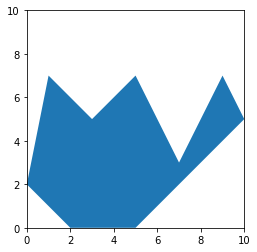

(0,3)
(1,8)
(3,6)
(5,8)
(6,6)
(7,4)
(8,6)
(9,8)
(10,6)
(5,1)
(2,1)


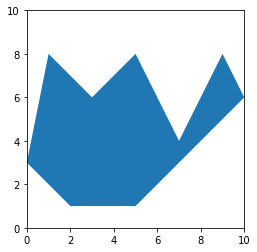

(0,4)
(1,9)
(3,7)
(5,9)
(6,7)
(7,5)
(8,7)
(9,9)
(10,7)
(5,2)
(2,2)


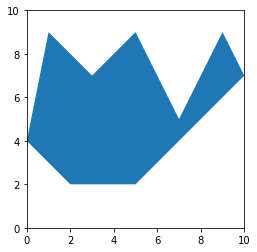

(0,5)
(1,10)
(3,8)
(5,10)
(6,8)
(7,6)
(8,8)
(9,10)
(10,8)
(5,3)
(2,3)


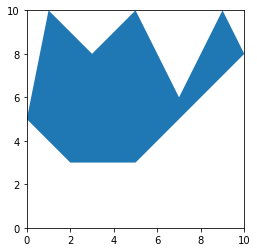

(0,6)
(1,11)
(3,9)
(5,11)
(6,9)
(7,7)
(8,9)
(9,11)
(10,9)
(5,4)
(2,4)


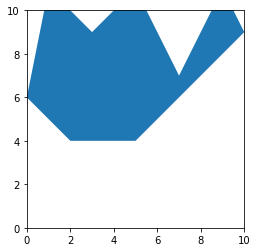

(0,7)
(1,12)
(3,10)
(5,12)
(6,10)
(7,8)
(8,10)
(9,12)
(10,10)
(5,5)
(2,5)


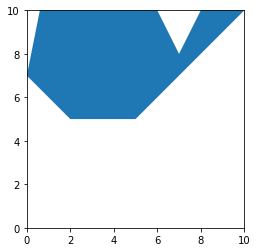

(1,7)
(2,12)
(4,10)
(6,12)
(7,10)
(8,8)
(9,10)
(10,12)
(11,10)
(6,5)
(3,5)


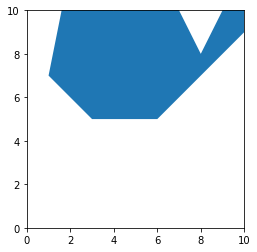

(2,7)
(3,12)
(5,10)
(7,12)
(8,10)
(9,8)
(10,10)
(11,12)
(12,10)
(7,5)
(4,5)


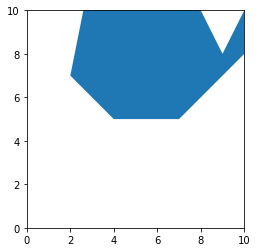

(2,2)
(3,7)
(5,5)
(7,7)
(8,5)
(9,3)
(10,5)
(11,7)
(12,5)
(7,0)
(4,0)


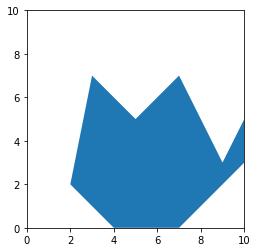

(2,3)
(3,8)
(5,6)
(7,8)
(8,6)
(9,4)
(10,6)
(11,8)
(12,6)
(7,1)
(4,1)


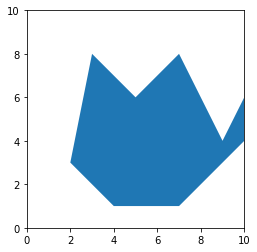

(2,4)
(3,9)
(5,7)
(7,9)
(8,7)
(9,5)
(10,7)
(11,9)
(12,7)
(7,2)
(4,2)


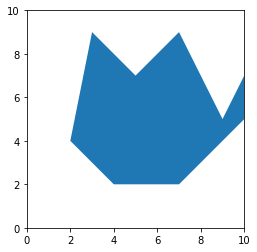

(2,5)
(3,10)
(5,8)
(7,10)
(8,8)
(9,6)
(10,8)
(11,10)
(12,8)
(7,3)
(4,3)


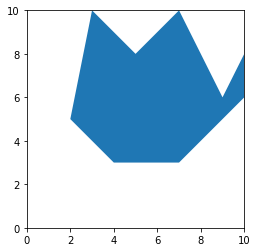

(1,2)
(2,7)
(4,5)
(6,7)
(7,5)
(8,3)
(9,5)
(10,7)
(11,5)
(6,0)
(3,0)


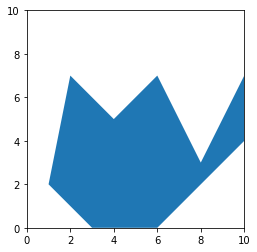

(1,3)
(2,8)
(4,6)
(6,8)
(7,6)
(8,4)
(9,6)
(10,8)
(11,6)
(6,1)
(3,1)


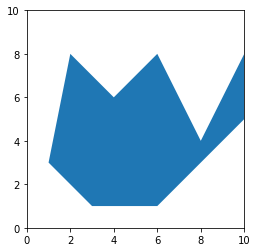

(1,4)
(2,9)
(4,7)
(6,9)
(7,7)
(8,5)
(9,7)
(10,9)
(11,7)
(6,2)
(3,2)


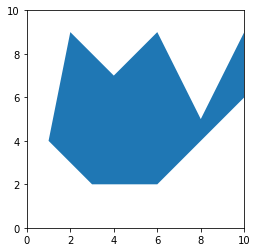

(1,5)
(2,10)
(4,8)
(6,10)
(7,8)
(8,6)
(9,8)
(10,10)
(11,8)
(6,3)
(3,3)


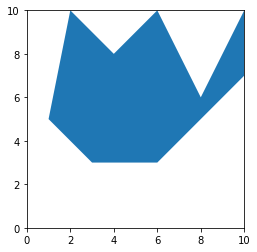

(1,6)
(2,11)
(4,9)
(6,11)
(7,9)
(8,7)
(9,9)
(10,11)
(11,9)
(6,4)
(3,4)


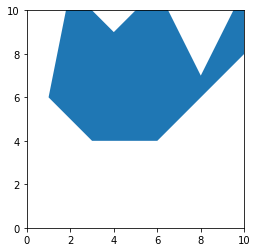

(2,6)
(3,11)
(5,9)
(7,11)
(8,9)
(9,7)
(10,9)
(11,11)
(12,9)
(7,4)
(4,4)


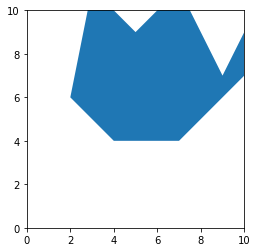

Status = FEASIBLE
Number of solutions found: 18


In [11]:
box = Box('box', 0, 0, 12, 12)

p1 = Point(0, 3)
p2 = Point(1, 8)
p3 = Point(3, 6)
p4 = Point(5, 8)
p5 = Point(6, 6)
p6 = Point(7, 4)
p7 = Point(8, 6)
p8 = Point(9, 8)
p9 = Point(10, 6)
p10 = Point(5, 1)
p11 = Point(2, 1)

pp = Point(3, 2)

piece1 = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11]

piece2 = [Point(2, 7), Point(2, 9), Point(4, 7), Point(4, 9)]

sh = Shape(piece1)

problem = BlockBoxProblemBis(box)
problem.addShape(sh)
problem.solve()